# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


# Описание данных  
Данные геологоразведки трёх регионов находятся в файлах:   
/datasets/geo_data_0.csv.   
/datasets/geo_data_1.csv.  
/datasets/geo_data_2.csv.   
id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  

## Загрузка и подготовка данных

In [1]:

#загруим все необходимые библиотеки и функции
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 

pd.options.mode.chained_assignment = None

Занесем бюджет на разработку скважин в регионе в переменную BUDGET.  
Стоимость одной тысячи баррель занесем в переменную PROFIT_PER_THOUSAND_BARREL.  
Количество разрабатываемых скважин занесем в параменную N.  

In [2]:

BUDGET=10_000_000_000
PROFIT_PER_THOUSAND_BARREL=450_000
N=200


Откроем файлы с данными и изучим данные, как видим, признаков не очень много, они количественные, id не будет участвовать в анализе, поэтому его можно удалить. Также в данных отсутствуют пропуски. 

In [3]:
data_0=pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
print(data_0.head())
print(data_0.info())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [5]:
data_1=pd.read_csv('/datasets/geo_data_1.csv')

In [6]:
print(data_1.head())
print(data_1.info())

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [7]:
data_2=pd.read_csv('/datasets/geo_data_2.csv')

In [8]:
print(data_2.head())
print(data_2.info())

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [9]:
print(data_0['id'].duplicated().sum())
print(data_1['id'].duplicated().sum())
print(data_2['id'].duplicated().sum())

10
4
4


In [10]:
data_0[data_0['id'].duplicated()]
data_0.query('id=="HZww2"')

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


In [11]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

<AxesSubplot:>

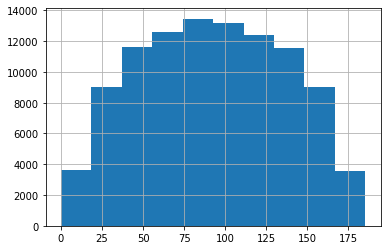

In [12]:
data_0['product'].hist()

<AxesSubplot:>

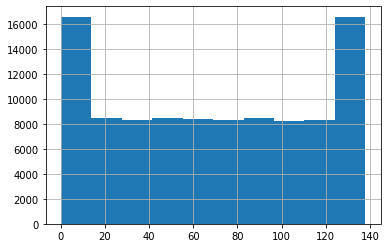

In [13]:
data_1['product'].hist()

<AxesSubplot:>

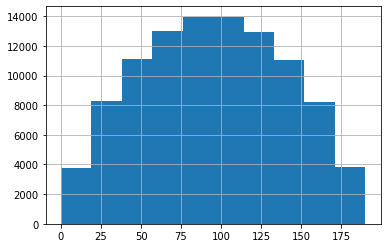

In [14]:
data_2['product'].hist()

Можно заметить,что распределение запасов во втором регионе не похоже на нормальное распределение (в отличии от 1 и 3 региона)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


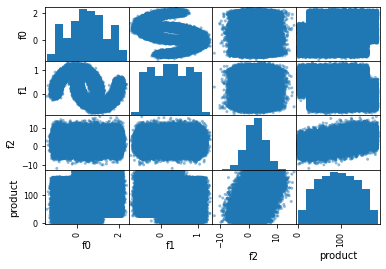

In [15]:
pd.plotting.scatter_matrix(data_0)
data_0.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


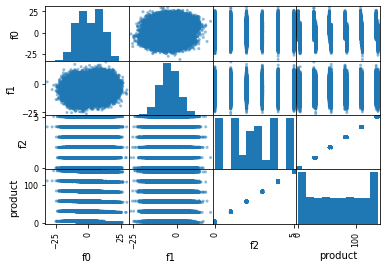

In [16]:
pd.plotting.scatter_matrix(data_1)
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


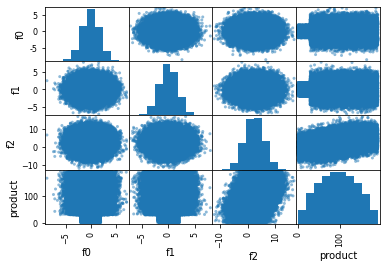

In [17]:
pd.plotting.scatter_matrix(data_2)
data_2.corr()

Как видно по матрице коэффициентов корреляции Пирсона в датасетах data_0 и data_2 (первая и третья скважины),  
не наблюдается сильной корреляции между какими - либо признаками. А в данных,относящихся ко второй скважине(data_1), есть очень высокая корреляция между целевыми признаком (объемом запасов в скважине) и признаком f2.


Напишем функцию для разделения дасатетов на обучающую и валидационную выборки. Также функция масштабирует количественные признаки, в нашем случае все признаки являются количественными (id из датасета мы уже удалили). 

In [18]:
def split(data):
    
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    
    numeric = pd.Series(features.columns)
    scaler = StandardScaler()
    features_train[numeric]=scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric]) 
    print(features_train.shape)
    print(features_valid.shape)
    print(target_train.shape)
    print(target_valid.shape)
    return features_train, features_valid, target_train, target_valid
  

In [19]:
split(data_0)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


(             f0        f1        f2
 27212 -0.544828  1.390264 -0.094959
 7866   1.455912 -0.480422  1.209567
 62041  0.260460  0.825069 -0.204865
 70185 -1.837105  0.010321 -0.147634
 82230 -1.299243  0.987558  1.273181
 ...         ...       ...       ...
 4094   1.567114 -1.087243 -0.272211
 85412 -1.904207 -0.525360  1.327530
 2177   0.418949 -1.296788 -0.196407
 77285  0.400077 -1.466874 -0.445317
 86498  1.746246  0.027415  2.766848
 
 [75000 rows x 3 columns],
              f0        f1        f2
 71751  0.517917 -0.610097 -0.126226
 80493  0.568391 -0.086063 -0.814914
 2655   0.805688 -1.613289 -1.341342
 53233  0.222503 -1.355437 -0.597275
 91141 -0.087941  1.433113 -0.544588
 ...         ...       ...       ...
 12581  1.541222 -0.709525  0.024535
 18456 -0.522565  0.474447 -0.103985
 73035 -0.138850  1.595071 -0.903485
 63834  0.658267 -1.428224  0.621967
 43558  1.409556 -0.650407  0.769670
 
 [25000 rows x 3 columns],
 27212    147.370612
 7866     147.630053
 62041     7

In [20]:
split(data_1)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


(             f0        f1        f2
 27212 -0.850855  0.624428  0.296943
 7866   1.971935  1.832275  0.294333
 62041  1.079305  0.170127 -0.296418
 70185 -1.512028 -0.887837 -0.880471
 82230 -1.804775 -0.718311 -0.293255
 ...         ...       ...       ...
 4094  -0.334573 -0.005156  0.295560
 85412  0.415280 -0.249559  0.877957
 2177   1.047070 -0.649992  1.473368
 77285 -0.114780 -1.190699  0.299156
 86498 -0.646146  0.099075  0.295611
 
 [75000 rows x 3 columns],
              f0        f1        f2
 71751 -0.168616  0.571372  0.297471
 80493  0.878384 -1.772903 -0.293901
 2655  -0.852976 -0.004986 -0.876502
 53233  1.496940 -1.146077 -0.294011
 91141  0.552177  0.057961 -1.457764
 ...         ...       ...       ...
 12581 -0.585274  0.036061  1.465670
 18456 -1.059992 -0.305376  0.880934
 73035 -1.146172 -0.119247  1.471417
 63834 -0.839466  0.785521  0.302943
 43558  1.048780 -0.275907 -0.295706
 
 [25000 rows x 3 columns],
 27212     84.038886
 7866      80.859783
 62041     5

In [21]:
split(data_2)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


(             f0        f1        f2
 27212 -0.526160  0.776329 -0.400793
 7866  -0.889625 -0.404070 -1.222936
 62041 -1.133984  0.208576  0.296765
 70185  1.227045  1.570166 -0.764556
 82230 -0.194289  0.878312  0.840821
 ...         ...       ...       ...
 4094  -1.815240  0.398261  1.821017
 85412 -0.274576 -1.265211  0.245519
 2177   0.368564  0.797225  0.665575
 77285 -2.440690  0.113784  0.440907
 86498 -1.732468  0.393573 -1.424465
 
 [75000 rows x 3 columns],
              f0        f1        f2
 71751 -0.836717 -2.227439 -0.078489
 80493 -0.821648  0.740237 -1.000811
 2655  -2.651336 -0.235721 -0.244546
 53233  1.077998  0.938090  0.511313
 91141 -1.173938  2.387270  1.034363
 ...         ...       ...       ...
 12581 -0.761845 -0.067861 -0.819227
 18456  0.006155  0.509468  0.030344
 73035  0.416444 -0.084595  0.218987
 63834 -0.136658 -0.101235 -0.870787
 43558 -1.359565 -0.598457  1.716644
 
 [25000 rows x 3 columns],
 27212     16.733577
 7866      38.047492
 62041    11

## Обучение и проверка модели

In [22]:
def model_fit(data):
    features_train, features_valid, target_train, target_valid = data
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('mean_predicted_product =',predicted_valid.mean()) #средний запас предсказанного сырья на одной скважине
    mse = mean_squared_error(target_valid,predicted_valid)
    print("RMSE =", mse ** 0.5)  #корень от среднеквадратичной ошибки
    return predicted_valid,target_valid,features_valid

print('Средний запас предсказанного сырья на одной скважине первого региона и RMSE')
model_0=model_fit(split(data_0))
print('\n')
print('Средний запас предсказанного сырья на одной скважине второго региона и RMSE')      
model_1=model_fit(split(data_1))
print('\n')
print('Средний запас предсказанного сырья на одной скважине третьего региона и RMSE')      
model_2=model_fit(split(data_2))

Средний запас предсказанного сырья на одной скважине первого региона и RMSE
(75000, 3)
(25000, 3)
(75000,)
(25000,)
mean_predicted_product = 92.59256778438035
RMSE = 37.5794217150813


Средний запас предсказанного сырья на одной скважине второго региона и RMSE
(75000, 3)
(25000, 3)
(75000,)
(25000,)
mean_predicted_product = 68.728546895446
RMSE = 0.893099286775617


Средний запас предсказанного сырья на одной скважине третьего региона и RMSE
(75000, 3)
(25000, 3)
(75000,)
(25000,)
mean_predicted_product = 94.96504596800489
RMSE = 40.02970873393434


Метрика RMSE минимальна для модели второго региона. Значит на данном этапе считаем ее наилучшей. 

## Подготовка к расчёту прибыли

In [23]:
data_0_mean_product=data_0['product'].mean()
data_1_mean_product=data_1['product'].mean()
data_2_mean_product=data_2['product'].mean()
print('Средний объём запасов в скважине первого региона')
print(data_0_mean_product)
print('\n')
print('Средний объём запасов в скважине второго региона')
print(data_1_mean_product)
print('\n')
print('Средний объём запасов в скважине третьего региона')
print(data_2_mean_product)

Средний объём запасов в скважине первого региона
92.50000000000001


Средний объём запасов в скважине второго региона
68.82500000000002


Средний объём запасов в скважине третьего региона
95.00000000000004


In [24]:
product_break_even=BUDGET/PROFIT_PER_THOUSAND_BARREL/N
print(round(product_break_even,2))

111.11


Чтобы окупить бюджет одна скважина должна иметь запас не менее 111 тыс баррелей, это выше чем средний запас по всем скважинам в трех регионах.  

## Расчёт прибыли и рисков 

Рассчитаем прибыль. Возьмем 200 скважин с наибольшими предсказаниями запасов.   
Возьмем реальные запасы на этих скважах и помножим на стоимость одного барреля.

In [25]:
def revenue(target,probs,count):
    probs_sorted = probs.sort_values(ascending=False) 
    selected = target[probs_sorted.index][:count] 
    return PROFIT_PER_THOUSAND_BARREL * selected.sum() - BUDGET
    
def calc_revenue(model):
    predicted_valid,target_valid,features_valid=model
    predicted_valid=pd.Series(predicted_valid)
    predicted_valid.index=features_valid.index
    print(revenue(target_valid,predicted_valid,N))
    return predicted_valid,target_valid

revenue_0=calc_revenue(model_0)
revenue_1=calc_revenue(model_1)
revenue_2=calc_revenue(model_2)

3320826043.1398506
2415086696.681511
2710349963.5998325


Пока выглядит так, что первая скважина принесет большую прибыль. Посмотрим на оценку рисков убытков.
Воспользуемся процедурой Bootstrap. 

In [26]:
def mean_revenue(model):
    predicted_valid,target_valid=model
    state = np.random.RandomState(12345)    
    values = []
    for i in range(1000):
        target_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        probs_subsample=predicted_valid[target_subsample.index] 
        values.append(revenue(target_subsample,probs_subsample,N))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()
    print("Средняя выручка:", mean)
    print("2,5%-квантиль:", lower)
    print('Риск убытков = {:.2%} '.format((values<0).mean()))

print('Первый регион:')
mean_revenue(revenue_0)
print('\n')
print('Второй регион:')
mean_revenue(revenue_1)
print('\n')
print('Третий регион:')
mean_revenue(revenue_2)

Первый регион:
Средняя выручка: 425938526.91059244
2,5%-квантиль: -102090094.83793654
Риск убытков = 6.00% 


Второй регион:
Средняя выручка: 515222773.4432899
2,5%-квантиль: 68873225.37050176
Риск убытков = 1.00% 


Третий регион:
Средняя выручка: 435008362.7827556
2,5%-квантиль: -128880547.32978901
Риск убытков = 6.40% 


По результатам оценки рисков с 99% вероятностью безубыточной будет разработка скважин во втором регионе. Поэтому выбираем его.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован